In [156]:
import numpy as np
import pandas as pd
from time import time
import warnings
warnings.filterwarnings(action="ignore", category=DeprecationWarning)

In [157]:
FIRST_SIZE = 2
STEP_SIZE = 8
LAST_SIZE = 2048 + FIRST_SIZE

COUNT_TRIES = 10

MAX_DEF_COUNT_ITER = 100000
"""Максимальное количество итераций по-умолчанию"""
DEF_EPS = 0.0001
"""Точность по-умолчанию"""

'Точность по-умолчанию'

In [158]:
(LAST_SIZE - FIRST_SIZE + 1), (LAST_SIZE - FIRST_SIZE + 1) / STEP_SIZE, ((LAST_SIZE - FIRST_SIZE) // STEP_SIZE + 1)

(2049, 256.125, 257)

In [159]:
df = pd.DataFrame(
    columns=[
        "size",
        "true_value_max",
        "true_value_min",
        "value_max",
        "value_max_time",
        "value_min_def",
        "value_min_def_time",
        # "value_min_rel",
        # "value_min_rel_time"
    ],
    index=range(1, ((LAST_SIZE - FIRST_SIZE) // STEP_SIZE + 1) * COUNT_TRIES + 1),
)
df

,size,true_value_max,true_value_min,value_max,value_max_time,value_min_def,value_min_def_time
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2566,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2567,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2568,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2569,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Подготовка

In [160]:
def calc(A: np.matrix, b: np.matrix) -> np.matrix:
    if b is None:
        print("Вектор собственного значения не был посчитан")
        return None
    return float((b.T @ A @ b) / (b.T @ b))

# Прямой метод

$x^{(k)} = \dfrac{Ax^{(k - 1)}}{\alpha_{k - 1}}$

$\lambda_{1}(A) = \dfrac{\left( Ax^{(k)}, x^{(k)} \right)}{(x^{(k)}, x^{(k)})} = \dfrac{(x^{(k)})^{T}A^{(k)}x^{(k)}}{(x^{(k)})^{T}x^{(k)}}$, где $|\lambda_1(A)|$ - наибольшее по модулю СЗ

In [161]:
def power_iteration(
    A: np.matrix,
    epsilon: float = DEF_EPS,
    num_iterations=MAX_DEF_COUNT_ITER,
    b_k: np.matrix = None,
) -> np.matrix:
    if b_k is None:
        b_k = np.random.rand(A.shape[1], 1)
    # print("Начальное приближение:", b_k, sep="\n")

    alpha_old = None

    # for _ in range(num_iterations):
    while True:
        b_k1 = np.dot(A, b_k)

        b_k1_norm = np.linalg.norm(b_k1)

        b_k = b_k1 / b_k1_norm

        alpha_new = calc(A, b_k)
        if alpha_old is not None and abs(alpha_new - alpha_old) < epsilon:
            break
        alpha_old = alpha_new

    return b_k, alpha_new

# Обратный метод

## Стандартная версия

In [162]:
def calc_LU(original: np.matrix) -> tuple[np.matrix, np.matrix]:
    matrixU = np.matrix(np.zeros(original.shape))
    matrixU[0] = original[0]

    matrixL = np.diag(np.ones((original.shape[0])))
    for i in range(original.shape[1]):
        matrixL[i, 0] = original[i, 0] / original[0, 0]

    for row in range(1, original.shape[0]):
        for column in range(1, original.shape[1]):
            if row <= column:
                elem_sum = sum(matrixL[row, i] * matrixU[i, column] for i in range(0, row - 1 + 1))
                matrixU[row, column] = original[row, column] - elem_sum
                continue
            elem_sum = sum(matrixL[row, i] * matrixU[i, column] for i in range(0, column - 1 + 1))
            matrixL[row, column] = (original[row, column] - elem_sum) / matrixU[column, column]
    return matrixL, matrixU

def get_inverse_LU(matrix):
    ML, MU = calc_LU(matrix)
    out_mt = np.zeros(matrix.shape)
    for iter in range(matrix.shape[0]):
        b = np.zeros((matrix.shape[0], 1))
        b[iter] = 1
        y = np.linalg.solve(ML, b)
        x = np.linalg.solve(MU, y)
        x = x.reshape((1, matrix.shape[0]))
        out_mt[:, iter] = x
    return out_mt

def inverse_power_def(
    A: np.matrix,
    epsilon: float = DEF_EPS,
    num_iterations=MAX_DEF_COUNT_ITER,
    b_k: np.matrix = None,
) -> np.matrix:
    try:
        inv_A = get_inverse_LU(A)
        # inv_A = np.linalg.inv(A)
    except np.linalg.LinAlgError:
        print("Вырожденная матрица")
        return None
    # print("Обратная матрица:",inv_A, sep="\n")
    res = power_iteration(
        A=inv_A, epsilon=epsilon, num_iterations=num_iterations, b_k=b_k
    )
    return res[0], 1 / res[1]

In [163]:
A: np.matrix = np.matrix("1 3 -2 0;"
                         "1 1 4 7;"
                         "4 7 11 23;"
                         "52 66 2 0")  # -0.65
calc(A, inverse_power_def(A)[0])

-0.6514132428966916

## Модификация Релэя

In [164]:
def inverse_power_rel(A, epsilon = DEF_EPS, mu = None, b_k = None):
  if b_k is None:
      b_k = np.random.rand(A.shape[1], 1) # Попробовать близкий к настоящему собственный вектор
      
  if mu is None:
    mu = np.random.randint(1, 1000) / 100
#   print("R:\n", mu, " ", b_k, "\n")
  
  b_k = b_k / np.linalg.norm(b_k)
  try:
    y = np.linalg.solve(A - mu * np.eye(A.shape[0]), b_k)
  except np.linalg.LinAlgError:
        print("Вырожденная матрица")
        return None, None
  # print(y)
  np.random.randint
  # print(x)
  lambda_ = float(np.dot(y.T, b_k))
  # print(lambda_, lambda_ * x)
  mu = mu + 1 / lambda_
  err = np.linalg.norm(y - lambda_ * b_k) / np.linalg.norm(y)

  while err > epsilon:
    b_k = y / np.linalg.norm(y)
    y = np.linalg.solve(A - mu * np.eye(A.shape[0]), b_k)
    lambda_ = float(np.dot(y.T, b_k))
    mu = mu + 1 / lambda_
    err = np.linalg.norm(y - lambda_ * b_k) / np.linalg.norm(y)

  return b_k, float(mu)

In [165]:
A: np.matrix = np.matrix("1 -2 -1;"
                         "-1 1 1;"
                         "1 0 -1")  # 0, 2, -1
# Сильно зависит от начального приближения
# Не вижу в ней смысла
inverse_power_rel(A)[1]
# calc(A, inverse_power_rel(A)[0])

8.841092707745376e-15

# Вычисление

In [166]:
def output(
    A: np.matrix,
    texts: list[str],
    funcs: list,
    num_iterrations: int = MAX_DEF_COUNT_ITER,
    b_k: np.matrix = None,
    mu: float = None,
) -> tuple[np.matrix, list[float | None]]:

    eigs = np.linalg.eigvals(A)
    # print(type(eigs[0]))
    if any(isinstance(eig, np.complex128) for eig in eigs):
        print(eigs)

    abs_v = np.abs(np.linalg.eigvals(A))

    abs_v_max = np.max(abs_v)

    abs_v_min = np.min(abs_v)
    # print(

    #     "Собственные значения матрицы A",

    #     f"Максимальное: {abs_v_max}",
    #     f"Минимальное: {abs_v_min}",
    #     sep="\n",
    # )

    # print("========")

    mass_eval = []

    for text, f in zip(texts, funcs):
        start_time = time()
        # print(text)
        if f.__name__ != inverse_power_rel.__name__:
            evec, eval = f(A=A, num_iterations=num_iterrations, b_k=b_k)
            # evec = f(A=A, num_iterations=num_iterrations, b_k=b_k)
            # eval = calc(A, evec)
        else:
            evec, eval = f(A=A, b_k=b_k, mu=mu)
        stop_time = time()
        # print("========")
        mass_eval.append(abs(eval))
        mass_eval.append(stop_time - start_time)

    # print(text_1)

    # first_evec = f_1(A=A, num_iterations=num_iterrations, b_k=b_k)

    # first_eval = calc(A, first_evec)
    # print("========")

    # print(text_2)

    # if f_2.__name__ != inverse_power_rel.__name__:

    #     second_evec = f_2(A=A, num_iterations=num_iterrations, b_k=b_k)

    #     second_eval = calc(A, second_evec)

    # else:

    #     second_evec, second_eval = f_2(A=A, b_k=b_k, mu=mu)
    # print("========")

    # print(

    #     "Собственные векторы:",

    #     f"{text_1}:",
    #     first_evec,

    #     f"{text_2}:",

    #     second_evec,

    #     sep="\n",
    # )
    # print(

    #     "Собственные значения:",

    #     f"{text_1}: {first_eval}",

    #     f"{text_2}: {second_eval}",

    #     sep="\n",
    # )

    return A.shape[0], abs_v_max, abs_v_min, *mass_eval

In [167]:
def generate_non_singular(n):
    while True:
        matrix = np.random.rand(n, n)
        if np.linalg.det(matrix) != 0:
            return matrix

In [168]:
# texts = ["Прямые итерации", "Обратные итерации (обычные)", "Обратные итерации (Релэя)"]
# funcs = [power_iteration, inverse_power_def, inverse_power_rel]
texts = ["Прямые итерации", "Обратные итерации (обычные)"]
funcs = [power_iteration, inverse_power_def]
mass = []

for i in range(FIRST_SIZE, LAST_SIZE + 1, STEP_SIZE):
    print(f"Current size:{i}")
    for j in range(COUNT_TRIES):
        print(j + 1)
        matr = generate_non_singular(i)
        matr = matr @ matr.T
        # Пришлось ввести симметричную матрицу из-за комплексных корней
        # В вычислениях проверять на комплексные корни
        df.iloc[((i - FIRST_SIZE) // STEP_SIZE) * COUNT_TRIES + j] = output(matr, texts, funcs)
    print()

df["delta_max"] = abs(df["true_value_max"] - df["value_max"])
df["delta_min_def"] = abs(df["true_value_min"] - df["value_min_def"])
# df["delta_min_rel"] = abs(df["true_value_min"] - df["value_min_rel"])

df

Current size:2
1
2
3
4
5
6
7
8
9
10

Current size:10
1
2
3
4
5
6
7
8
9
10

Current size:18
1
2
3
4
5
6
7
8
9
10

Current size:26
1
2
3
4
5
6
7
8
9
10

Current size:34
1
2
3
4
5
6
7
8
9
10

Current size:42
1
2
3
4
5
6
7
8
9
10

Current size:50
1
2
3
4
5
6
7
8
9
10

Current size:58
1
2
3
4
5
6
7
8
9
10

Current size:66
1
2
3
4
5
6
7
8
9
10

Current size:74
1
2
3
4
5
6
7
8
9
10

Current size:82
1
2
3
4
5
6
7
8
9
10

Current size:90
1
2
3
4
5
6
7
8
9
10

Current size:98
1
2
3
4
5
6
7
8
9


KeyboardInterrupt: 

In [133]:
df

,size,true_value_max,true_value_min,value_max,value_max_time,value_min_def,value_min_def_time,delta_max,delta_min_def
1,2,0.650187,0.002995,0.650187,0.0,0.002995,0.0,0.0,0.0
2,2,0.322017,0.07268,0.322015,0.0,0.07268,0.0,0.000001,0.0
3,2,0.628855,0.136547,0.628854,0.0,0.136547,0.0,0.0,0.0
4,2,1.59526,0.151224,1.59526,0.0,0.151224,0.0,0.0,0.0
5,2,1.005368,0.218852,1.005368,0.0,0.218852,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
196,192,9304.296547,0.000003,9304.296547,0.0,0.000003,1.758418,0.0,0.0
197,192,9247.117256,0.00001,9247.117256,0.0,0.00001,1.756588,0.0,0.0
198,192,9371.968041,0.000105,9371.968041,0.00051,0.000105,1.717529,0.0,0.0
199,192,9200.240508,0.001006,9200.240508,0.0,0.001006,1.719693,0.0,0.0


In [134]:
df.sort_values("delta_max", ascending=False).head(10)

,size,true_value_max,true_value_min,value_max,value_max_time,value_min_def,value_min_def_time,delta_max,delta_min_def
9,2,0.767608,0.427134,0.767581,0.0,0.427137,0.0,0.000027,0.000003
2,2,0.322017,0.07268,0.322015,0.0,0.07268,0.0,0.000001,0.0
5,2,1.005368,0.218852,1.005368,0.0,0.218852,0.0,0.0,0.0
3,2,0.628855,0.136547,0.628854,0.0,0.136547,0.0,0.0,0.0
20,12,38.80818,0.008567,38.80818,0.0,0.008567,0.0,0.0,0.0
13,12,38.874429,0.000001,38.874429,0.00086,0.000001,0.000052,0.0,0.0
26,22,111.157008,0.000428,111.157008,0.0,0.000428,0.003005,0.0,0.0
25,22,116.442085,0.001189,116.442085,0.0,0.001189,0.003503,0.0,0.0
4,2,1.59526,0.151224,1.59526,0.0,0.151224,0.0,0.0,0.0
12,12,39.712533,0.000956,39.712533,0.0,0.000956,0.000998,0.0,0.0


In [135]:
df.sort_values("delta_min_def", ascending=False).head(10)

,size,true_value_max,true_value_min,value_max,value_max_time,value_min_def,value_min_def_time,delta_max,delta_min_def
9,2,0.767608,0.427134,0.767581,0.0,0.427137,0.0,0.000027,0.000003
5,2,1.005368,0.218852,1.005368,0.0,0.218852,0.0,0.0,0.0
17,12,36.225424,0.035329,36.225424,0.0,0.035329,0.0,0.0,0.0
3,2,0.628855,0.136547,0.628854,0.0,0.136547,0.0,0.0,0.0
4,2,1.59526,0.151224,1.59526,0.0,0.151224,0.0,0.0,0.0
47,42,441.173182,0.004683,441.173182,0.0,0.004683,0.025217,0.0,0.0
48,42,457.80747,0.005762,457.80747,0.0,0.005762,0.019044,0.0,0.0
2,2,0.322017,0.07268,0.322015,0.0,0.07268,0.0,0.000001,0.0
78,72,1324.290121,0.005824,1324.290121,0.0,0.005824,0.101451,0.0,0.0
83,82,1727.263025,0.005535,1727.263025,0.0,0.005535,0.143444,0.0,0.0


In [ ]:
# df.sort_values("delta_min_rel", ascending=False).head(10)

# Графическая часть

In [137]:
import matplotlib.pyplot as plt

In [138]:
# res_df = df[["size", "value_max_time", "value_min_def_time", "value_min_rel_time", "delta_max", "delta_min_def", "delta_min_rel"]]
res_df = df[["size", "value_max_time", "value_min_def_time", "delta_max", "delta_min_def"]]
figsize = (18, 6)
b_k = range(FIRST_SIZE, LAST_SIZE + 1, STEP_SIZE * 4)
x_lt = np.linspace(FIRST_SIZE, LAST_SIZE)
res_df

,size,value_max_time,value_min_def_time,delta_max,delta_min_def
1,2,0.0,0.0,0.0,0.0
2,2,0.0,0.0,0.000001,0.0
3,2,0.0,0.0,0.0,0.0
4,2,0.0,0.0,0.0,0.0
5,2,0.0,0.0,0.0,0.0
...,...,...,...,...,...
196,192,0.0,1.758418,0.0,0.0
197,192,0.0,1.756588,0.0,0.0
198,192,0.00051,1.717529,0.0,0.0
199,192,0.0,1.719693,0.0,0.0


In [139]:
max(res_df["delta_min_def"])

np.float64(3.4066922027786717e-06)

In [ ]:
# max(res_df["delta_min_rel"])

In [141]:
mean_df = res_df.groupby("size").mean()
mean_df

,value_max_time,value_min_def_time,delta_max,delta_min_def
size,,,,
2,0.000051,0.000005,0.000003,0.0
12,0.000324,0.000679,0.0,0.0
22,0.000051,0.004075,0.0,0.0
32,0.0,0.010861,0.0,0.0
42,0.0,0.024095,0.0,0.0
52,0.0,0.038866,0.0,0.0
62,0.0,0.066891,0.0,0.0
72,0.000052,0.10071,0.0,0.0
82,0.0,0.145397,0.0,0.0


In [142]:
max(mean_df['delta_min_def'])

3.557588510810349e-07

In [ ]:
# max(mean_df['delta_min_def']), max(mean_df['delta_min_rel'])

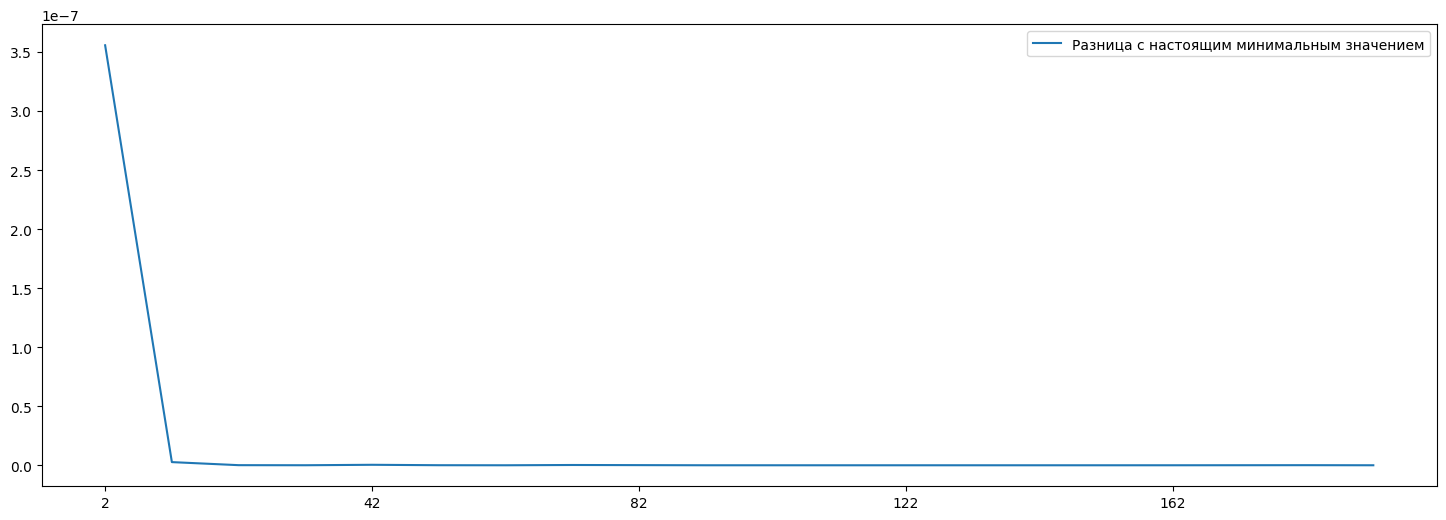

In [ ]:

plt.figure(figsize=figsize)
plt.xticks(ticks=b_k)
ax1.set_xlabel('Размер матрицы')
plt.plot(mean_df["delta_min_def"], label="Разница с настоящим минимальным значением")
plt.legend()
# mean_res.plot()

In [145]:

# plt.figure(figsize=figsize)
# plt.xticks(ticks=b_k)

# plt.plot(mean_df["delta_min_rel"])
# plt.legend(["delta on minimum (relay)"])
# # mean_res.plot()

2.932487610568524e-06


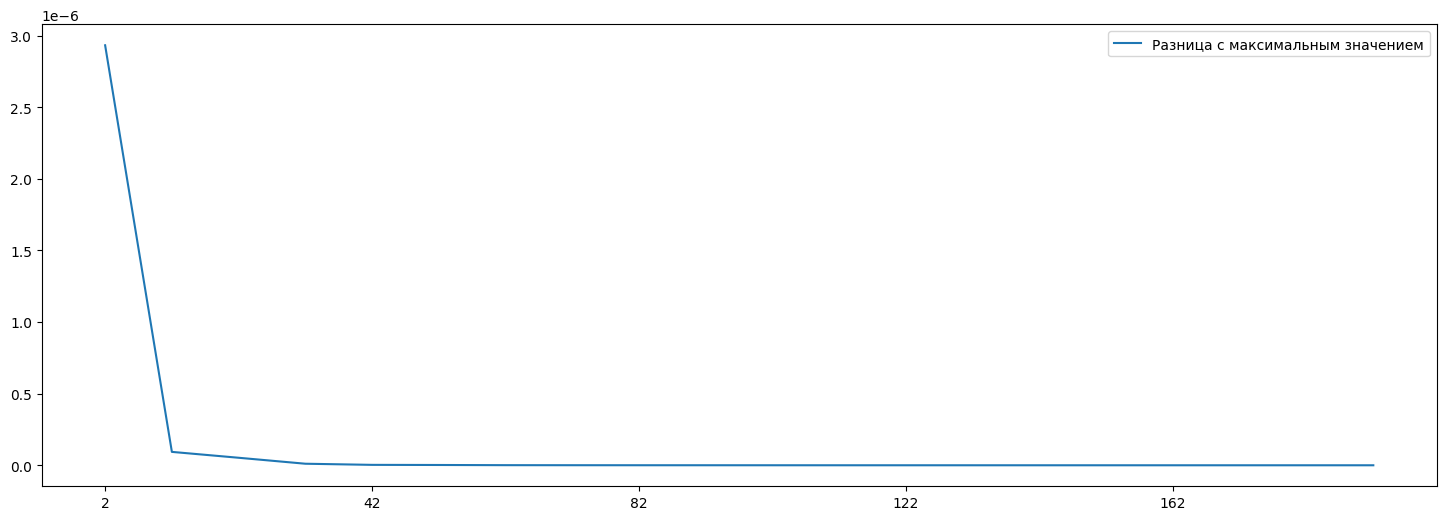

In [155]:
print(max(mean_df['delta_max']))
plt.figure(figsize=figsize)
ax1.set_xlabel('Размер матрицы')
plt.xticks(ticks=b_k)
plt.plot(mean_df["delta_max"], label="Разница с максимальным значением")
plt.legend()

<Figure size 1800x600 with 0 Axes>

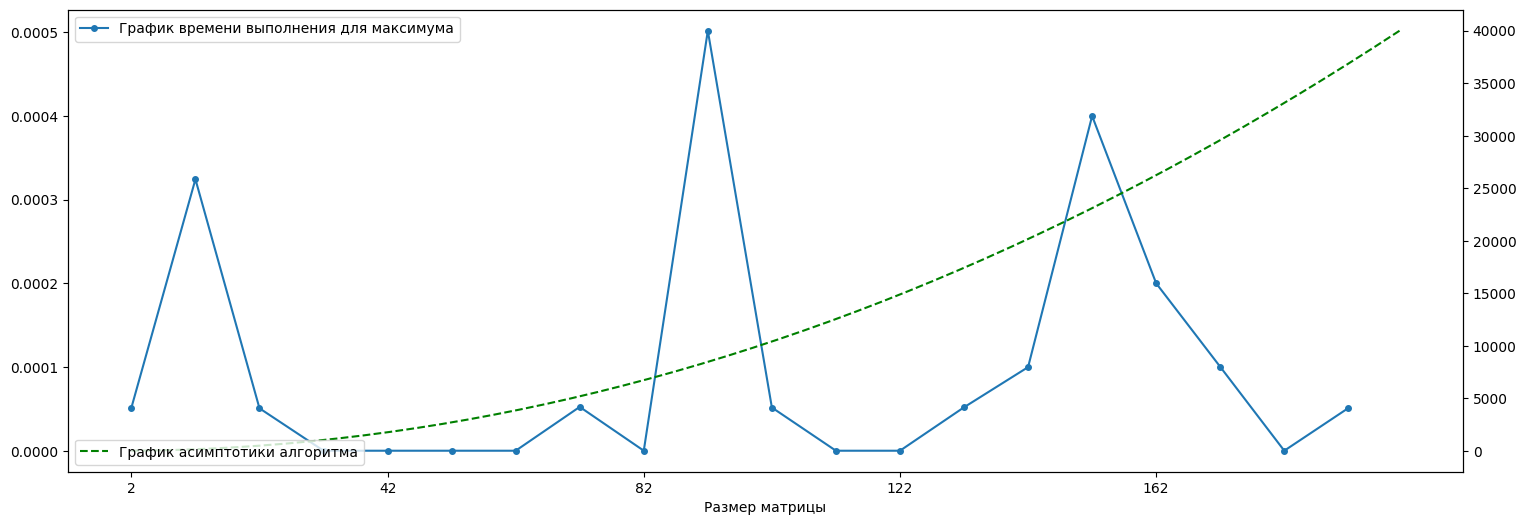

In [ ]:
plt.figure(figsize=figsize)

fig, ax1 = plt.subplots(figsize=figsize)

ax1.plot(mean_df['value_max_time'],  marker='o',  markersize=4, label='График времени выполнения для максимума')
ax1.set_xlabel('Размер матрицы')
ax1.set_xticks(b_k)

ax2 = ax1.twinx()

ax2.plot(x_lt, x_lt ** 2, color='green', linestyle='--', label='График асимптотики алгоритма')

ax1.legend(loc='upper left')
ax2.legend(loc='lower left')

plt.show()
# plt.xticks(ticks=x)
# plt.legend(["time for calculation of maximum"])


<Figure size 1800x600 with 0 Axes>

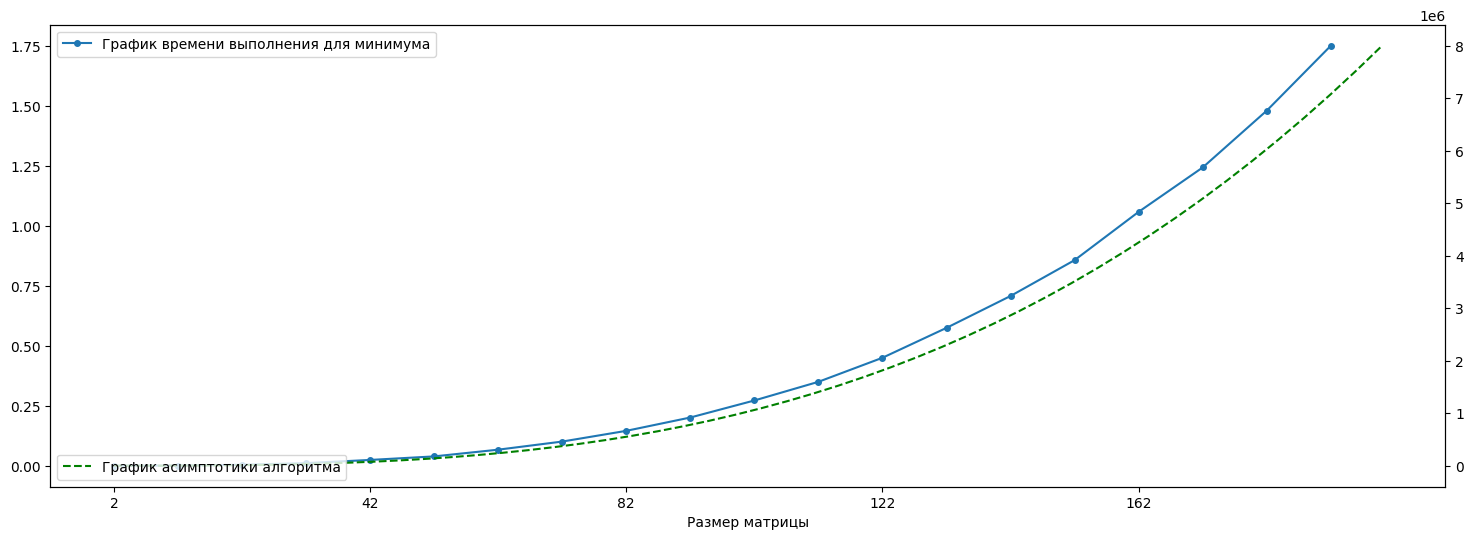

In [148]:
plt.figure(figsize=figsize)

fig, ax1 = plt.subplots(figsize=figsize)

ax1.plot(mean_df['value_min_def_time'],  marker='o',  markersize=4, label='График времени выполнения для минимума')
ax1.set_xlabel('Размер матрицы')
ax1.set_xticks(b_k)

ax2 = ax1.twinx()

ax2.plot(x_lt, x_lt ** 3, color='green', linestyle='--', label='График асимптотики алгоритма')

ax1.legend(loc='upper left')
ax2.legend(loc='lower left')
# plt.plot(x=x, y=x**2)
# plt.legend(["time for calculation of minimum"])
plt.show()

In [149]:
# plt.figure(figsize=figsize)

# fig, ax1 = plt.subplots(figsize=figsize)

# ax1.plot(mean_df['delta_min_rel'],  marker='o',  markersize=4, label='График времени выполнения для Рэлея')
# ax1.set_xlabel('Размер матрицы')
# ax1.set_xticks(b_k)

# ax2 = ax1.twinx()

# ax2.plot(x_lt, x_lt ** 3, color='green', linestyle='--', label='График асимптотики алгоритма')

# ax1.legend(loc='upper left')
# ax2.legend(loc='lower left')
# # plt.plot(x=x, y=x**2)
# # plt.legend(["time for calculation of minimum"])
# plt.show()

In [150]:
# df.to_csv("data/df.csv")
# mean_df.to_csv("data/mean_df.csv")
# res_df.to_csv("data/res_df.csv")